In [1]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker,SafeMaskMaker
from gammapy.irf import EDispKernel
from gammapy.makers.utils import make_psf_map
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)
from gammapy.modeling import Fit

1.0


In [2]:
import os
os.chdir('../EventDataset/')
from EventDatasetMaker import EventDatasetMaker
from EventDataset import EventDataset

In [3]:
%load_ext autoreload
%autoreload 2

## Set up a binned and unbinned Dataset

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [5]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.geomspace(0.5,100,40) # a fine binning in true energy
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.01,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [6]:
%%time
maker = MapDatasetMaker(selection=["counts", 'exposure','edisp', 'background', 'psf'])
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg', bias_percent=8)

reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model

CPU times: user 3.31 s, sys: 786 ms, total: 4.1 s
Wall time: 4.15 s


In [7]:
%%time
test_maker = EventDatasetMaker(safe_mask_maker=maker_safe_mask, selection=None)
test_eds = test_maker.run(reference, obs1)

bkg_model2 = FoVBackgroundModel(dataset_name=test_eds.name)
test_eds.models=bkg_model2

CPU times: user 2.88 s, sys: 724 ms, total: 3.6 s
Wall time: 3.62 s


In [8]:
dataset.counts.data.sum(), dataset.counts.data[dataset.mask].sum()

(4881.0, 3385.0)

In [9]:
test_eds.event_mask, test_eds.event_mask.sum(), test_eds.event_mask.shape

(array([False,  True, False, ..., False,  True,  True]), 3385, (7613,))

## Test model evaluation

In [10]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )
model_gauss.spatial_model.parameters.freeze_all()
dataset.models = [bkg_model,model_gauss]
test_eds.models = [bkg_model2,model_gauss.copy(name="crab_model_gauss")]

In [11]:
print(test_eds.models)

DatasetModels

Component 0: FoVBackgroundModel

  Name                      : xRciRuX2-bkg
  Datasets names            : ['xRciRuX2']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         

Component 1: SkyModel

  Name                      : crab_model_gauss
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.50e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      1.800   +/-    0.00             
    beta                          :      0.400   +/-    0.00             
    lon_0                 (frozen):    184

In [12]:
test_eds.stat_sum()

-84543.4124430513

In [13]:
dataset.stat_sum()

45531.416864558654

In [14]:
%%time
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run([dataset])
print(result)
result.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 134
	total stat : 45261.73

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 12.3 s, sys: 3.17 s, total: 15.5 s
Wall time: 15.5 s


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,1.3045e+00,,2.389e-02,nan,nan,False,True,
spectral,amplitude,5.1488e-11,cm-2 s-1 TeV-1,3.837e-12,nan,nan,False,True,
spectral,alpha,3.1971e+00,,1.754e-01,nan,nan,False,False,
spectral,beta,-1.3115e-01,,8.036e-02,nan,nan,False,False,


In [15]:
%%time
result2 = fit.run([test_eds])
print(result2)
result2.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 139
	total stat : -84816.12

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 21.8 s, sys: 14.6 s, total: 36.4 s
Wall time: 36.5 s


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,1.3326e+00,,2.391e-02,nan,nan,False,True,
spectral,amplitude,3.9658e-11,cm-2 s-1 TeV-1,3.218e-12,nan,nan,False,True,
spectral,alpha,3.0262e+00,,1.809e-01,nan,nan,False,False,
spectral,beta,-7.3439e-02,,8.898e-02,nan,nan,False,False,


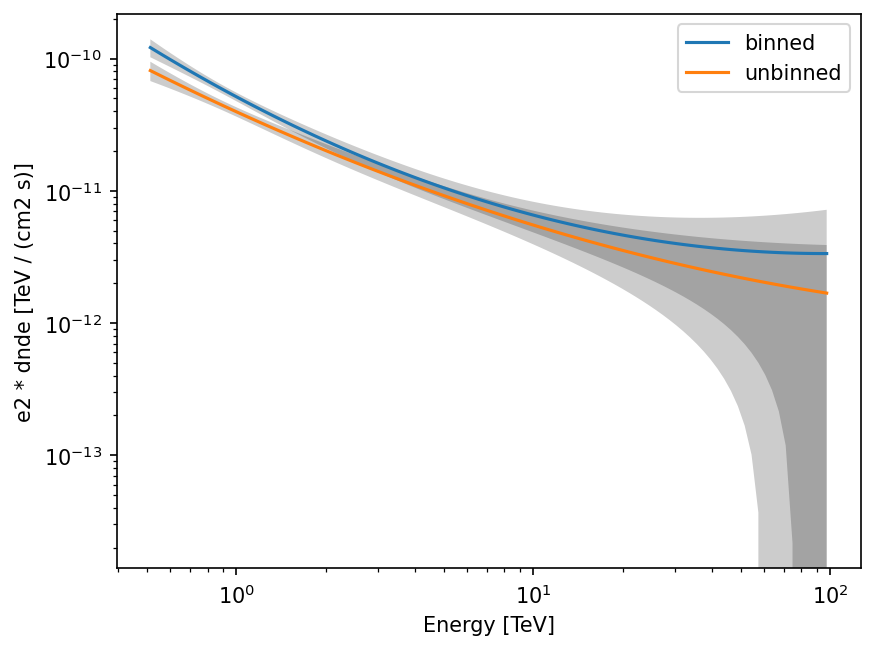

In [16]:
plt.figure(dpi=150)
dataset.models["crab_model_gauss"].spectral_model.plot(dataset.energy_range_total, energy_power=2, label="binned")
dataset.models["crab_model_gauss"].spectral_model.plot_error(dataset.energy_range_total, energy_power=2)
test_eds.models["crab_model_gauss"].spectral_model.plot(dataset.energy_range_total, energy_power=2, label="unbinned")
test_eds.models["crab_model_gauss"].spectral_model.plot_error(dataset.energy_range_total, energy_power=2)
plt.legend()